<a href="https://colab.research.google.com/github/MarijkeBeersmans/MiddelNER-Middelnederlandse-named-entity-recognition/blob/main/ModelMiddelNederlandseNER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Middelnederlandse NER

## prep

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional, Input
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import f1_score, classification_report
print(tf.__version__)

#to get reproducible results
#restart the runtime after running this cel
tf.random.set_seed(1234)
np.random.seed(1234)

import spacy
print(spacy.__version__) #we need version 3 or higher
!pip install --upgrade spacy
!pip install transformers
!pip install seqeval
!pip install datasets

2.8.2
3.4.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/MarijkeBeersmans/MiddelNER-Middelnederlandse-named-entity-recognition.git

fatal: destination path 'MiddelNER-Middelnederlandse-named-entity-recognition' already exists and is not an empty directory.


In [3]:
%cd /content/MiddelNER-Middelnederlandse-named-entity-recognition

/content/MiddelNER-Middelnederlandse-named-entity-recognition


In [4]:
path = 'C14NL-PoS-annotated/TRAIN.tsv'
TRAIN_DF = pd.read_csv(path, sep="\t", encoding = "UTF-8", header=None)

path2 = 'C14NL-PoS-annotated/TEST.tsv'
TEST_DF = pd.read_csv(path2, sep="\t", encoding = "UTF-8", header=None)

path3 = 'C14NL-PoS-annotated/DEV.tsv'
DEV_DF = pd.read_csv(path3, sep="\t", encoding = "UTF-8", header=None)

from string import punctuation

def clean_words(word):
  word = word.casefold()
  word = word.translate(str.maketrans('', '', punctuation))
  return word

# print(TRAIN[0])
TRAIN_DF[0] = TRAIN_DF[0].apply(clean_words)
DEV_DF[0] = DEV_DF[0].apply(clean_words)
TEST_DF[0] = TEST_DF[0].apply(clean_words)

TRAIN_DF.head()

,0,1,2,3,4
0,wi,O,365,O098p33302,1
1,hebben,O,365,O098p33302,1
2,ij,B-MONEY,365,O098p33302,1
3,sc,I-MONEY,365,O098p33302,1
4,par,I-MONEY,365,O098p33302,1


In [5]:
def split(list_a, chunk_size):

  for i in range(0, len(list_a), chunk_size):
    yield list_a[i:i + chunk_size]

def map_sentence(s):
  doc = [(w, t) for w, t in zip(s[0].values.tolist(),
                                      s[1].values.tolist())]
  chunks = split(doc, 250)
  return chunks
     
def get_sent(df):
  grouped = df.groupby(2).apply(map_sentence)
  sentences = [chunk for s in grouped for chunk in s]
  return sentences

## With a single Bi-LSTM layer

In [6]:
TRAIN = get_sent(TRAIN_DF)
TEST = get_sent(TEST_DF)
DEV = get_sent(DEV_DF)

TRAIN[0]

[('wi', 'O'),
 ('hebben', 'O'),
 ('ij', 'B-MONEY'),
 ('sc', 'I-MONEY'),
 ('par', 'I-MONEY'),
 ('vte', 'O'),
 ('den', 'O'),
 ('ghemene', 'O'),
 ('dachwande', 'O'),
 ('ter', 'O'),
 ('doot', 'O'),
 ('e', 'O'),
 ('door', 'O'),
 ('moet', 'O'),
 ('derfachteghede', 'O'),
 ('vzoeke', 'O'),
 ('e', 'O'),
 ('gheuen', 'O'),
 ('onsen', 'O'),
 ('meyere', 'O'),
 ('vi', 'B-MONEY'),
 ('d', 'I-MONEY'),
 ('et', 'O'),
 ('elken', 'O'),
 ('van', 'O'),
 ('seuen', 'O'),
 ('ghesuoren', 'O'),
 ('laten', 'O'),
 ('die', 'O'),
 ('wi', 'O'),
 ('daer', 'O'),
 ('hebben', 'O'),
 ('i', 'B-MONEY'),
 ('d', 'I-MONEY'),
 ('en', 'O'),
 ('maecht', 'O'),
 ('een', 'O'),
 ('mensche', 'O'),
 ('vzoeken', 'O'),
 ('ouer', 'O'),
 ('al', 'O'),
 ('door', 'O'),
 ('maer', 'O'),
 ('de', 'O'),
 ('meyer', 'O'),
 ('e', 'O'),
 ('de', 'O'),
 ('late', 'O'),
 ('vors', 'O'),
 ('moeten', 'O'),
 ('haer', 'O'),
 ('recht', 'O'),
 ('hebben', 'O'),
 ('van', 'O'),
 ('elken', 'O'),
 ('dier', 'O'),
 ('an', 'O'),
 ('marchiert', 'O'),
 ('hoe', 'O'),
 ('dat

In [7]:
uniq_words = sorted(set(list(TRAIN_DF[0])))
uniq_tags = list(TRAIN_DF[1].unique())

# Dictionary word to index
word2idx = {w : i + 2 for i, w in enumerate(uniq_words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0

# Dictionary label to index 
tag2idx = {t : i + 1 for i, t in enumerate(uniq_tags)}
tag2idx["PAD"] = 0

idx2word = {i: w for w, i in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

['', '1', '12', '2', 'a', 'abbedesse', 'abbedessen', 'abboet', 'abdesse', 'abdt', 'abedesse', 'abedessen', 'abelijns', 'abt', 'abyte', 'achstersten', 'achte', 'achten', 'achtensten', 'achtentach', 'achter', 'achterdeele', 'achterhaeld', 'achterhuus', 'achterstelle', 'achtersten', 'achterster', 'achtetach', 'achtiensten', 'acker', 'adde', 'adden', 'adelijsse', 'adelincs', 'adelincx', 'adelings', 'adelinx', 'adryaen', 'adryaens', 'adryane', 'aechte', 'aechten', 'aedeghe', 'aeldinghe', 'aelmoesen', 'aelmoesene', 'aelmoesenen', 'aelmonsenen', 'aen', 'aensiende', 'aergheren', 'aermoesenen', 'aernoud', 'af', 'afghewonne', 'afwinne', 'afwinnighe', 'al', 'ald', 'aldaert', 'alden', 'alder', 'aldus', 'alemoesene', 'alemoessenen', 'alf', 'algheheel', 'alkes', 'alle', 'alleene', 'allen', 'alleuene', 'allice', 'allicen', 'allinc', 'allinghe', 'alloese', 'alm', 'alme', 'alnaect', 'alnde', 'alre', 'als', 'alsbrouc', 'alse', 'alselken', 'alser', 'alsij', 'alsire', 'also', 'alsoe', 'alsoec', 'alsoet', 

In [8]:
len(word2idx), len(uniq_words), len(tag2idx), len(uniq_tags), len(idx2word), len(idx2tag)

(4666, 4664, 10, 9, 4666, 10)

In [9]:
idx2word[15], word2idx["jaer"], tag2idx['B-PERS'], idx2tag[5]

('abt', 1863, 4, 'I-PERS')

In [10]:
X_train = [[w[0] for w in s] for s in TRAIN]
y_train = [[w[1] for w in s] for s in TRAIN]


X_test = [[w[0] for w in s] for s in TEST]
y_test = [[w[1] for w in s] for s in TEST]

X_dev = [[w[0] for w in s] for s in DEV]
y_dev = [[w[1] for w in s] for s in DEV]

In [11]:
max_len = max([len(s) for s in TRAIN])
# X_train

X_train_tokens = [[word2idx[w] for w in s] for s in X_train]
y_train_cat = [[tag2idx[w] for w in s] for s in y_train]
y_train_cat = [to_categorical(i, num_classes = len(tag2idx)) for i in y_train_cat]


# Let's limit or pad each sequence to have sentences of the same length
X_train_tokens= pad_sequences(maxlen = max_len, sequences = X_train_tokens, padding = "post", value = word2idx["PAD"])
y_train_cat = pad_sequences(maxlen = max_len, sequences = y_train_cat, padding = "post", value = tag2idx["PAD"])


X_test_tokens = [[word2idx[w] if w in word2idx.keys() else 1 for w in s] for s in X_test]
y_test_cat = [[tag2idx[w] for w in s] for s in y_test]
y_test_cat = [to_categorical(i, num_classes = len(tag2idx)) for i in y_test_cat]


# Let's limit or pad each sequence to have sentences of the same length
X_test_tokens= pad_sequences(maxlen = max_len, sequences = X_test_tokens, padding = "post", value = word2idx["PAD"])
y_test_cat = pad_sequences(maxlen = max_len, sequences = y_test_cat, padding = "post", value = tag2idx["PAD"])

X_dev_tokens = [[word2idx[w] if w in word2idx.keys() else 1 for w in s] for s in X_dev]
y_dev_cat = [[tag2idx[w] for w in s] for s in y_dev]
y_dev_cat = [to_categorical(i, num_classes = len(tag2idx)) for i in y_dev_cat]

# Let's limit or pad each sequence to have sentences of the same length
X_dev_tokens= pad_sequences(maxlen = max_len, sequences = X_dev_tokens, padding = "post", value = word2idx["PAD"])
y_dev_cat = pad_sequences(maxlen = max_len, sequences = y_dev_cat, padding = "post", value = tag2idx["PAD"])

In [12]:
# Number of data points passed in each iteration
batch_size = 64 
# Passes through entire dataset
epochs = 100
# Dimension of embedding vector
embedding_size = 100
# number of 
n_units = 100
# learning rate
lr = 0.001
# validation split
val_split=0.1

num_words = len(word2idx)

In [13]:
from sklearn.utils.extmath import softmax
num_words = len(word2idx)

import tensorflow.keras as keras

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

model = keras.Sequential()
model.add(keras.layers.Embedding(num_words, embedding_size, input_length=max_len, mask_zero=True))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(embedding_size, return_sequences=True,)))
model.add(keras.layers.Dense(len(tag2idx), activation='softmax', name='output'))

model.summary() # explain params
optimizer = keras.optimizers.Adam(learning_rate=lr)

model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.fit(X_train_tokens, y_train_cat, batch_size=batch_size, epochs=epochs,
          validation_data=(X_dev_tokens, y_dev_cat), callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          466600    
                                                                 
 bidirectional (Bidirectiona  (None, 250, 200)         160800    
 l)                                                              
                                                                 
 output (Dense)              (None, 250, 10)           2010      
                                                                 
Total params: 629,410
Trainable params: 629,410
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 15s 2s/step - loss: 1.6388 - accuracy: 0.6069 - val_loss: 1.6708 - val_accuracy: 0.8512
Epoch 2/100
4/4 [==============================] - 3s 751ms/step - loss: 1.5076 - accuracy: 0.8374 - val_loss

In [14]:
from sklearn import metrics

def flat_classification_report(y_true, y_pred):
  y_true_report = []
  y_pred_report = []

  for item in y_true:
    y_true_report+= item

  for item in y_pred:
    y_pred_report+= item

  y_pred_report = [item if item != 'PAD' else 'O' for item in y_pred_report]
 
  return metrics.classification_report(y_true_report, y_pred_report)

def predict_test(my_model): 
  y_pred = my_model.predict(X_test_tokens)
  y_pred = np.argmax(y_pred, axis=-1)
  y_pred = [[idx2tag[i] for i in row] for row in y_pred]
  y_pred = [y_seq[:len(y_test[i])] for i, y_seq in enumerate(y_pred)]
  return y_pred


y_pred = predict_test(model)
print(flat_classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

      B-DATE       0.93      0.68      0.78        40
       B-LOC       0.83      0.56      0.67        85
     B-MONEY       0.74      0.64      0.69        53
      B-PERS       0.94      0.80      0.86       254
      I-DATE       0.96      0.66      0.78       151
       I-LOC       1.00      0.10      0.18        10
     I-MONEY       0.85      0.93      0.89       123
      I-PERS       0.88      0.63      0.73       224
           O       0.95      0.99      0.97      4310

    accuracy                           0.94      5250
   macro avg       0.90      0.67      0.73      5250
weighted avg       0.94      0.94      0.93      5250



In [15]:
flat_X_test = [item for lst in X_test for item in lst]
flat_y_test = [item for lst in y_test for item in lst]
flat_y_pred = [item for lst in y_pred for item in lst]

df_errors = pd.DataFrame(list(zip(flat_X_test, flat_y_test, flat_y_pred)), columns=['word', 'ent', 'prediction'])

In [16]:
df_errors.head(20)

df_errors[df_errors['ent'] != df_errors['prediction']]

df_errors[10:5000]

,word,ent,prediction
10,sinte,O,B-LOC
11,clare,O,O
12,typre,B-LOC,B-LOC
13,kenne,O,O
14,dat,O,O
...,...,...,...
4995,gheerart,B-PERS,B-PERS
4996,wauel,I-PERS,I-PERS
4997,alse,O,O
4998,schepenne,O,O


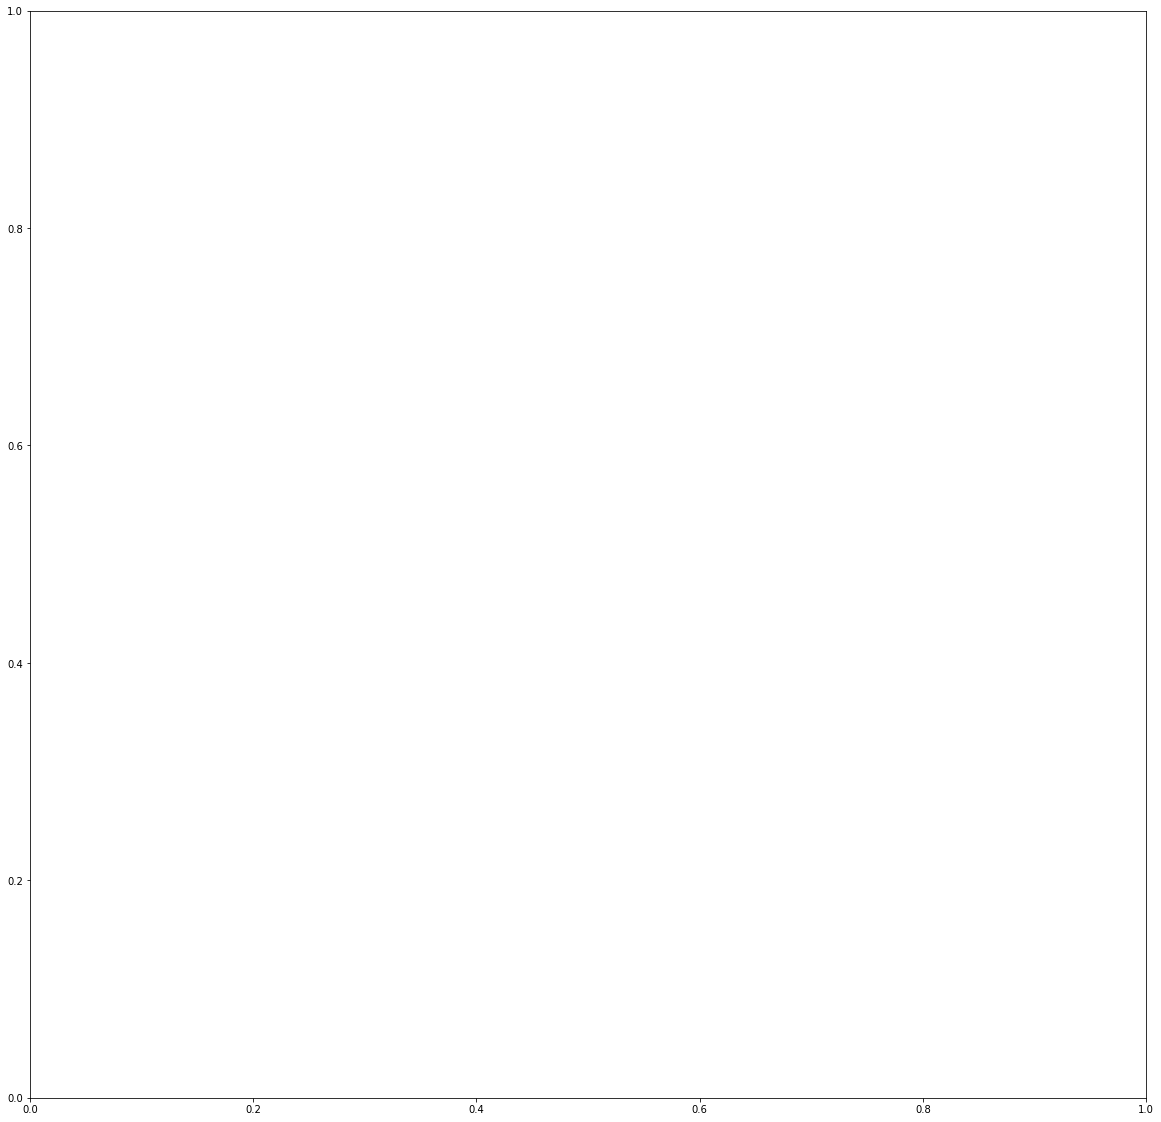

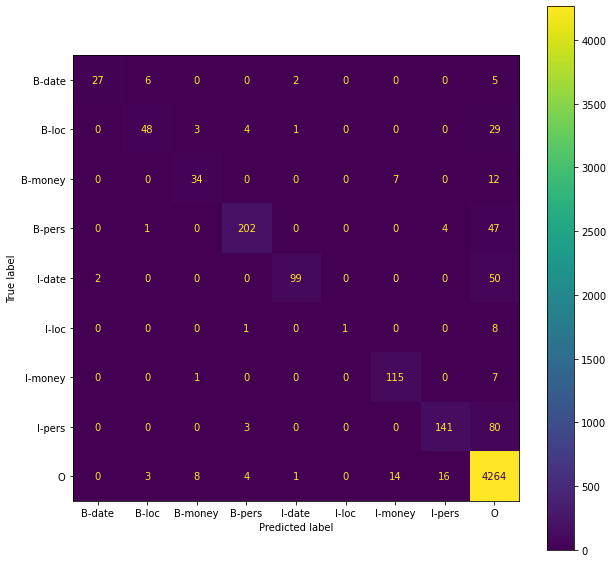

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(20, 20))

labels = ['B-date', 'B-loc', 'B-money', 'B-pers', 'I-date', 'I-loc', 'I-money', 'I-pers', 'O']

fig, ax = plt.subplots(figsize=(10,10))
cm = confusion_matrix(flat_y_test, flat_y_pred)
disp = ConfusionMatrixDisplay.from_predictions(flat_y_test, flat_y_pred,
                           display_labels=labels, ax=ax)


In [20]:
#from charter H084p35401

txt = """Wie jacob van den houke wydoot brunijnc Robrecht lammertijn artur veyse en jehan abelkin Scepene van der poort van veurne doen te wetene 
tallen den gonen die deze lre zullen zien of horen leisen Dat jehan de buc de tanne en pieroene zijn wijf camen voor ons Ende ghauen vp wel en 
wettlike met halme en met ghiften jehan den breden onzen poorte zes sceleghe par. siaers eweliker renten den groten tournoisen ouer 
twalef peninghe par. of andre munte jnt auenant ligghende onder de stede trechof en de recken die jehans van den recke waren daer 
hanekin vranke nu wonende es te gheldene jehan den brede vors. of den ex bringhe van deze  lre te tween payementen jnt jaer dats te  
wetene dene helt te zinte jehans messe nu eerst"""

txt = clean_words(txt)

def predict_classes(my_model, input_txt):
  input_txt = input_txt.split()
  input_tokens = [[word2idx[w] if w in word2idx.keys() else 1 for w in input_txt]]
  input_tokens = pad_sequences(maxlen = 250, sequences = input_tokens, padding = "post", value = word2idx["PAD"]) 
  y_pred = my_model.predict(input_tokens)
  y_pred = np.argmax(y_pred, axis=-1)
  y_pred = [[idx2tag[i] for i in row] for row in y_pred]
  # y_pred = [y_seq[:len(y_test[i])] for i, y_seq in enumerate(y_pred)]
  return y_pred

pred = predict_classes(model, txt)

flat_pred = [item for l in pred for item in l]

df_errors = pd.DataFrame(list(zip(txt.split(), flat_pred)), columns=['word','prediction'])

In [21]:

import nltk
nltk.download('averaged_perceptron_tagger')

from nltk import pos_tag
from nltk.tree import Tree
from nltk.chunk import conlltags2tree
tokens = df_errors['word']
tags = df_errors['prediction']
# tag each token with pos
pos_tags = [pos for token, pos in pos_tag(tokens)]
# convert the BIO / IOB tags to tree
conlltags = [(token, pos, tg) for token, pos, tg in zip(tokens, pos_tags, tags)]
ne_tree = conlltags2tree(conlltags)
# parse the tree to get our original text
original_text = []
for subtree in ne_tree:
    # checking for 'O' tags
    if type(subtree) == Tree:
        original_label = subtree.label()
        original_string = " ".join([token for token, pos in                      subtree.leaves()])
        original_text.append((original_string, original_label))
print(original_text)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('jacob van den houke wydoot', 'PERS'), ('robrecht lammertijn artur', 'PERS'), ('jehan abelkin', 'PERS'), ('jehan de buc de', 'PERS'), ('jehan den', 'PERS'), ('zes sceleghe par', 'MONEY'), ('twalef peninghe par', 'MONEY'), ('jehans van', 'PERS'), ('jehan den', 'PERS'), ('zinte jehans messe nu eerst', 'DATE')]


## With BERT

In [118]:
# !pip install transformers
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer

In [119]:
TRAIN_DF.head()
DEV_DF.head()
TEST_DF.head()

,0,1,2,3,4
0,wie,O,688,H072p40001,140
1,suster,O,688,H072p40001,140
2,lisebette,B-PERS,688,H072p40001,140
3,bi,O,688,H072p40001,140
4,den,O,688,H072p40001,140


In [120]:
def chunk_df(df):
  counter = 0
  new_df = pd.DataFrame(columns=['token', 'tag', 'num'])

  sentences = get_sent(df)

  for chunk in sentences:
    chunk = pd.DataFrame(chunk, columns=['token', 'tag'])
    chunk['num'] = counter
    counter = counter + 1
    new_df = new_df.append(chunk)

  return new_df

In [121]:
def split(list_a, chunk_size):

  for i in range(0, len(list_a), chunk_size):
    yield list_a[i:i + chunk_size]

def map_sentence(s):
  doc = [(w, t) for w, t in zip(s[0].values.tolist(),
                                      s[1].values.tolist())]
  chunks = split(doc, 100)
  return list(chunks)
     
def get_sent(df):
  grouped = df.groupby(2).apply(map_sentence)
  sentences = [chunk for s in grouped for chunk in s]
  return sentences

In [122]:
import json

label_dict = {'O': 0, 
 'B-PERS': 1, 
 'I-PERS': 2, 
 'B-LOC': 3, 
 'I-LOC': 4, 
 'B-MONEY': 5, 
 'I-MONEY': 6, 
 'B-DATE': 7,
 'I-DATE': 8}


TRAIN_DF[1] = TRAIN_DF[1].apply(lambda x:label_dict[x])
for row in TRAIN_DF[1]:
  assert type(row) == int
DEV_DF[1] = DEV_DF[1].apply(lambda x: label_dict[x])
for row in DEV_DF[1]:
  assert type(row) == int
TEST_DF[1] = TEST_DF[1].apply(lambda x: label_dict[x])
for row in TEST_DF[1]:
  assert type(row) == int

def get_dataset(df):
  for_BERT = []
  
  df = chunk_df(df)
  df_GROUPED = df.groupby('num')
  for group in df_GROUPED.groups:
    group = df_GROUPED.get_group(group)
    tokens = list(group['token'])
    tags = list(group['tag'])
    # for element in tags:
    #   assert type(element) == int
    dct = {'tokens': tokens, 'tags': tags}
    for_BERT.append(json.dumps(dct, ensure_ascii=False))

  return for_BERT

TRAIN_json = get_dataset(TRAIN_DF)

print(TRAIN_json)

import os

os.makedirs("data/Middelner", exist_ok=True)
with open("data/Middelner/train.json", "w+") as f:
    f.write("\n".join(TRAIN_json))


['{"tokens": ["wi", "hebben", "ij", "sc", "par", "vte", "den", "ghemene", "dachwande", "ter", "doot", "e", "door", "moet", "derfachteghede", "vzoeke", "e", "gheuen", "onsen", "meyere", "vi", "d", "et", "elken", "van", "seuen", "ghesuoren", "laten", "die", "wi", "daer", "hebben", "i", "d", "en", "maecht", "een", "mensche", "vzoeken", "ouer", "al", "door", "maer", "de", "meyer", "e", "de", "late", "vors", "moeten", "haer", "recht", "hebben", "van", "elken", "dier", "an", "marchiert", "hoe", "dat", "ne", "waer", "een", "vzoect", "dit", "was", "wetteleke", "vclareert", "bi", "maninghen", "va", "boidin", "keyacke", "te", "dien", "tiden", "onse", "meyere", "e", "bi", "vonnesse", "va", "zeuen", "ghezuornen", "laten", "e", "bi", "consente", "va", "der", "peuzen", "zuste", "e", "broede", "va", "den", "spet", "e", "ooc", "bi"], "tags": [0, 0, 5, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [123]:
!tail data/Middelner/train.json

{"tokens": ["van", "ziere", "zielen", "ziner", "vader", "ende", "moeder", "ziner", "vrienden", "ende", "allen", "anderen", "zielen", "daer", "af", "dat", "hi", "yet", "te", "bet", "heeft", "ghehadt", "in", "sinen", "leuene", "heeft", "ghekent", "ende", "ghelijt", "kent", "ende", "lijt", "dat", "hi", "heeft", "ghegheuen", "teeweliken", "daghen", "voert", "meer", "ende", "gheeft", "als", "nv", "bi", "der", "tenueren", "van", "desen", "wetteliken", "brieuen", "puerlijc", "om", "gode", "ende", "in", "puerer", "aermoesenen", "fransen", "van", "der", "beke", "clerc", "vten", "bisscopdomme", "van", "doernike", "als", "nv", "capellaen", "zijnde", "van", "der", "vors", "capellen", "ter", "vors", "capelrien", "bouf", "ende", "anders", "niet", "ende", "in", "vermeereringhen", "ende", "verbeteringhe", "van", "der", "vors", "capelrien", "ende", "van", "den", "dienste", "ende", "loue", "van", "gode", "een"], "tags": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [124]:
TEST_json = get_dataset(TEST_DF)

os.makedirs("data/Middelner", exist_ok=True)
with open("data/Middelner/test.json", "w+") as f:
    f.write("\n".join(TEST_json))

DEV_json = get_dataset(DEV_DF)

os.makedirs("data/Middelner", exist_ok=True)
with open("data/Middelner/validation.json", "w+") as f:
    f.write("\n".join(DEV_json))

In [125]:
!tail data/Middelner/validation.json

{"tokens": ["vriheden", "altoes", "behauden", "lijsbetten", "ende", "callen", "vors", "hare", "vors", "xl", "s", "par", "siaers", "de", "welke", "xl", "sc", "par", "siaers", "erfeleker", "renten", "mathijs", "vors", "heeft", "belooft", "bewijst", "en", "beset", "op", "de", "vors", "erue", "en", "haboet", "alsoe", "voren", "verclaert", "jn", "kenness", "van", "wareden", "so", "hebben", "wy", "franss", "crupenninc", "franss", "van", "der", "crayen", "en", "jan", "jacops", "als", "schepn", "in", "audende", "in", "desen", "tijt", "dese", "pnte", "cyrogphie", "ghezeghelt", "elc", "onser", "met", "zinen", "ppren", "zeghele", "vte", "hanghende", "dit", "was", "ghedaen", "jnt", "jaer", "xiijciiijxx", "en", "xix", "den", "xxviijste", "dach", "van", "septembre"], "tags": [0, 0, 0, 1, 0, 1, 0, 0, 0, 5, 6, 6, 0, 0, 0, 5, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2, 2, 0, 1, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [126]:
# !pip install datasets

from datasets import load_dataset

dataset = load_dataset("data/Middelner")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/Middelner-97c6b14c52405fbe/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [127]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 463
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 61
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 71
    })
})

In [128]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")

In [129]:
# label_names = ['O', 
#     'B-PERS', 
#     'I-PERS', 
#     'B-LOC', 
#     'I-LOC', 
#     'B-MONEY', 
#     'I-MONEY', 
#     'B-DATE',
#     'I-DATE']

id2label={0:'O', 
     1 : 'B-PERS', 
     2 : 'I-PERS', 
     3 : 'B-LOC', 
     4 : 'I-LOC', 
     5 : 'B-MONEY', 
     6 : 'I-MONEY', 
     7 : 'B-DATE',
     8 : 'I-DATE'}

label_names = list(label_dict.values())

# print(label_names)
# for label in label_names:
#   print(type(label))

In [130]:
#Get the values for input_ids, token_type_ids, attention_mask
def tokenize_adjust_labels(all_samples_per_split):
  tokenized_samples = tokenizer.batch_encode_plus(all_samples_per_split["tokens"], is_split_into_words=True, truncation=True, max_length=512, add_special_tokens = True)
  #tokenized_samples is not a datasets object so this alone won't work with Trainer API, hence map is used 
  #so the new keys [input_ids, labels (after adjustment)]
  #can be added to the datasets dict for each train test validation split
  total_adjusted_labels = []
  print(len(tokenized_samples["input_ids"]))
  for k in range(0, len(tokenized_samples["input_ids"])):
    prev_wid = -1
    word_ids_list = tokenized_samples.word_ids(batch_index=k)
    existing_label_ids = all_samples_per_split["tags"][k]
    i = -1
    adjusted_label_ids = []
   
    for wid in word_ids_list:
      if(wid is None):
        adjusted_label_ids.append(-100)
      elif(wid!=prev_wid):
        i = i + 1
        adjusted_label_ids.append(existing_label_ids[i])
        prev_wid = wid
      else:
        label_name = label_names[existing_label_ids[i]]
        adjusted_label_ids.append(existing_label_ids[i])
        
    total_adjusted_labels.append(adjusted_label_ids)
  tokenized_samples["labels"] = total_adjusted_labels
  return tokenized_samples

tokenized_dataset = dataset.map(tokenize_adjust_labels, batched=True)


  0%|          | 0/1 [00:00<?, ?ba/s]

463


  0%|          | 0/1 [00:00<?, ?ba/s]

61


  0%|          | 0/1 [00:00<?, ?ba/s]

71


In [131]:
tokenized_dataset['train'][1]

{'tokens': ['csente',
  'va',
  'ghemene',
  'laten',
  'die',
  'wi',
  'hebben',
  'te',
  'duseb',
  'en',
  'was',
  'ghedaen',
  'jnt',
  'jaer',
  'mccc',
  'et',
  'xxxiij',
  'sdonresdaechs',
  'na',
  'zentelucien',
  'dach'],
 'tags': [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 7, 8, 8, 8, 8, 8, 8],
 'input_ids': [1,
  30026,
  131,
  25108,
  28902,
  20673,
  30029,
  25913,
  25108,
  117,
  14872,
  10669,
  22444,
  13106,
  19883,
  11070,
  117,
  114,
  11281,
  22250,
  30029,
  25883,
  24770,
  25108,
  30032,
  126,
  132,
  13912,
  25138,
  30035,
  24545,
  115,
  30027,
  132,
  30044,
  29807,
  121,
  26148,
  30041,
  24906,
  28110,
  24770,
  25002,
  131,
  15885,
  22674,
  126,
  28929,
  29167,
  121,
  25108,
  10461,
  24570,
  2],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [132]:
# !pip install seqeval

from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import numpy as np
from datasets import load_metric
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

metric = load_metric("seqeval")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    flattened_results = {
        "overall_precision": results["overall_precision"],
        "overall_recall": results["overall_recall"],
        "overall_f1": results["overall_f1"],
        "overall_accuracy": results["overall_accuracy"],
    }
    return flattened_results

In [133]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [134]:
tokenizer.mask_token_id

4

In [135]:
import torch
torch.cuda.empty_cache()

model = AutoModelForTokenClassification.from_pretrained(
    "GroNLP/bert-base-dutch-cased", num_labels=len(label_names),
    label2id={0: 0, 
     1 : 1, 
     2 : 2, 
     3 : 3, 
     4 : 4, 
     5 : 5, 
     6 : 6, 
     7 : 7,
     8 : 8},
    id2label={0:'O', 
     1 : 'B-PERS', 
     2 : 'I-PERS', 
     3 : 'B-LOC', 
     4 : 'I-LOC', 
     5 : 'B-MONEY', 
     6 : 'I-MONEY', 
     7 : 'B-DATE',
     8 : 'I-DATE'},
     )

training_args = TrainingArguments(
    output_dir="./fine_tune_bert_output",
    evaluation_strategy="epoch",
    logging_strategy="epoch", 
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_steps = 1000,
    report_to="tensorboard",
    run_name = "ep_10_tokenized_11",
    save_strategy='no',
    warmup_ratio = 0.1 
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased

Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,1.344400,0.746166,0.000000,0.000000,0.000000,0.820938
2,0.651700,0.465443,0.000000,0.000000,0.000000,0.865722
3,0.366200,0.299780,0.000000,0.000000,0.000000,0.907291
4,0.235500,0.242537,0.000000,0.000000,0.000000,0.931181
5,0.171800,0.216037,0.000000,0.000000,0.000000,0.939217
6,0.136800,0.208569,0.000000,0.000000,0.000000,0.939144
7,0.118600,0.194715,0.000000,0.000000,0.000000,0.943673
8,0.107900,0.193974,0.000000,0.000000,0.000000,0.945938


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tags, tokens. If tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 71
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 3 seems not to be NE tag.
  w

TrainOutput(global_step=232, training_loss=0.3916089318949601, metrics={'train_runtime': 190.1748, 'train_samples_per_second': 19.477, 'train_steps_per_second': 1.22, 'total_flos': 469929086309448.0, 'train_loss': 0.3916089318949601, 'epoch': 8.0})

In [136]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tags, tokens. If tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 71
  Batch size = 16


{'eval_loss': 0.19397394359111786,
 'eval_overall_precision': 0.0,
 'eval_overall_recall': 0.0,
 'eval_overall_f1': 0.0,
 'eval_overall_accuracy': 0.94593804792519,
 'eval_runtime': 1.6719,
 'eval_samples_per_second': 42.466,
 'eval_steps_per_second': 2.991,
 'epoch': 8.0}

In [137]:
# trainer.to('gpu')

predictions = trainer.predict(tokenized_dataset['test'])

The following columns in the test set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tags, tokens. If tags, tokens are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 61
  Batch size = 16


### spaghetticode hack to get classification report

In [138]:
import torch

model.to('cpu')

model = model
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
predictionzzz = []
token_list = []

for txt in tokenized_dataset['test']['tokens']:
  sequence = ' '.join(txt)
  inputs = tokenizer(sequence, return_tensors="pt")
  tokens = inputs.tokens()
  print(tokens)
  token_list.append(tokens)
  
  outputs = model(**inputs).logits
  predictions = torch.argmax(outputs, dim=2)
  predictionzzz.append(predictions)

print(predictionzzz)

loading configuration file https://huggingface.co/GroNLP/bert-base-dutch-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/443c1d513d458927e5883e0b1298cdb70ba4d14a55faa236d93e0598efc78fc7.3b16931b59b9aafc3e068b6cd5f0be5e02a209a299e39b1e0056d89eaa3b6a7b
Model config BertConfig {
  "_name_or_path": "GroNLP/bert-base-dutch-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30073
}

loading file https://huggingface.co/GroNLP

['[CLS]', 'wie', 'su', '##ster', 'li', '##s', '##e', '##bet', '##te', 'bi', 'de', '##n', 'g', '##he', '##do', '##ghe', 'van', 'god', '##e', 'ab', '##de', '##sse', 'va', 'sin', '##te', 'cl', '##are', 't', '##y', '##pre', 'ken', '##n', '##e', 'dat', 'j', '##c', 'heb', '##be', 'ont', '##fan', '##ghe', '##n', 'van', 'de', '##r', 'st', '##eid', '##e', 'va', 'y', '##pre', 'in', 'de', 'name', 'en', 'o', '##u', '##er', 'su', '##ster', 'kat', '##eli', '##n', '##e', 's', '##mis', '##en', 'non', '##n', '##e', 'in', 'ons', '##en', 'cl', '##oos', '##ter', 'x', '##xi', '##i', '##ij', 'l', '##b', 'par', 'als', 'va', 'de', 'pa', '##iem', '##en', '##te', 'dat', 'ha', '##er', 'viel', 'de', 'x', '##v', '##sten', 'da', '##ch', 'va', 'la', '##u', 'ma', '##en', '##t', 'va', 'de', 'welke', 'pa', '##i', '##ment', '##e', 'voor', '##s', 'en', 'van', 'alle', 'verleiden', '##e', 'pa', '##iem', '##en', '##te', 'en', 'al', 'dat', 'a', '##to', '##uchi', '##eren', 'ma', '##ch', 'om', '##me', 'ca', '##us', '##e', 'van

In [139]:
# print(len(predictionzzz))

fml = []

for t in predictionzzz:
  for x in t:
    fml = fml + list(x)

fml2 = []

for t in tokenized_dataset['test']['labels']:
  fml2 = fml2 + t

fml3 = []

for t in token_list:
  for token in t :
    fml3 = fml3 + [token]

print(len(fml))
print(len(fml2))
print(len(fml3))

11547
11547
11547


In [140]:
df = pd.DataFrame(list(zip(fml, fml2, fml3)),
               columns =['y_pred', 'y_true', 'tokens'])

In [141]:
df = df.drop(df[df['y_true'] == -100].index)
df

,y_pred,y_true,tokens
1,tensor(0),0,wie
2,tensor(0),0,su
3,tensor(0),0,##ster
4,tensor(1),1,li
5,tensor(1),1,##s
...,...,...,...
11541,tensor(8),0,##t
11542,tensor(8),0,k
11543,tensor(8),0,##er
11544,tensor(8),0,##cho


In [142]:
print('[SEP]' in df.tokens.unique())
print('[CLS]' in df.tokens.unique())

False
False


In [143]:
df.reset_index(drop=True, inplace=True)
df

,y_pred,y_true,tokens
0,tensor(0),0,wie
1,tensor(0),0,su
2,tensor(0),0,##ster
3,tensor(1),1,li
4,tensor(1),1,##s
...,...,...,...
11420,tensor(8),0,##t
11421,tensor(8),0,k
11422,tensor(8),0,##er
11423,tensor(8),0,##cho


In [144]:
def expand_lists_sym(*lists, elements):
  assert len(lists) == len(elements)
  for lst, e in zip(lists, elements):
    lst.append(e)
  return lists

def fix_output(df):
  fixed_y_true = []
  fixed_y_pred = []
  fixed_token = []
  token = []
  true_label = []
  pred_label = []

  for i in range(len(df)):
    assert type(i) == int
    lp = df.loc[i, 'y_pred']
    lt = df.loc[i, 'y_true'] 
    t = df.loc[i, 'tokens']


    if len(token) == 0:
      token, true_label, pred_label = expand_lists_sym(token, 
                                                       true_label, pred_label, 
                                                       elements=[t, lt, lp])

    else:
      if t.startswith('##'):
        token, true_label, pred_label = expand_lists_sym(token, 
                                                       true_label, pred_label, 
                                                       elements=[t, lt, lp])

      else:
        word = ''.join(token).replace('##', '')
        label = int(np.mean(true_label))
        label_pred = int(np.mean(pred_label))
        fixed_y_true, fixed_y_pred, fixed_token = expand_lists_sym(fixed_y_true, 
                                                      fixed_y_pred, fixed_token, 
                                                      elements=[label, label_pred, word])
        token = [t]
        true_label = [lt]
        pred_label = [lp]
    
  word = ''.join(token).replace('##', '')
  label = int(np.mean(true_label))
  label_pred = int(np.mean(pred_label))

  fixed_y_true, fixed_y_pred, fixed_token = expand_lists_sym(fixed_y_true, 
                                                      fixed_y_pred, fixed_token, 
                                                      elements=[label, label_pred, word])

  return fixed_y_true, fixed_y_pred, fixed_token




In [145]:
y_true, y_pred, tokens = fix_output(df)

new_df = pd.DataFrame(list(zip(y_true, y_pred, tokens)),
               columns =['y-true', 'y_pred', 'tokens'])
new_df.head()

,y-true,y_pred,tokens
0,0,0,wie
1,0,0,suster
2,1,1,lisebette
3,0,0,bi
4,0,0,den


In [146]:
new_df

,y-true,y_pred,tokens
0,0,0,wie
1,0,0,suster
2,1,1,lisebette
3,0,0,bi
4,0,0,den
...,...,...,...
5245,0,0,der
5246,0,2,peuser
5247,0,5,camere
5248,0,2,ant


In [147]:
from sklearn.metrics import classification_report

y_pred = [id2label[int(x)] for x in list(new_df['y_pred'])]
y_true = [id2label[int(x)] for x in list(new_df['y-true'])]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      B-DATE       0.68      0.70      0.69        40
       B-LOC       0.67      0.61      0.64        85
     B-MONEY       0.78      0.87      0.82        53
      B-PERS       0.69      0.81      0.74       254
      I-DATE       0.91      0.77      0.83       151
       I-LOC       0.00      0.00      0.00        10
     I-MONEY       0.87      0.90      0.88       123
      I-PERS       0.73      0.79      0.76       224
           O       0.97      0.96      0.97      4310

    accuracy                           0.93      5250
   macro avg       0.70      0.71      0.70      5250
weighted avg       0.93      0.93      0.93      5250



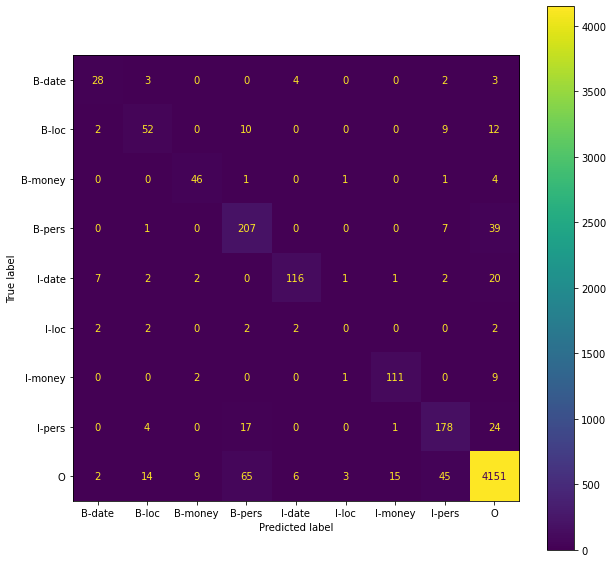

In [151]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ['B-date', 'B-loc', 'B-money', 'B-pers', 'I-date', 'I-loc', 'I-money', 'I-pers', 'O']

fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                           display_labels=labels, ax=ax)

In [ ]:
# Bit of a hack to get the tokens with the special tokens
tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
inputs = tokenizer.encode(sequence, return_tensors="pt")

outputs = model(inputs)[0]
predictions = torch.argmax(outputs, dim=2)

print([(token, id2label[prediction]) for token, prediction in zip(tokens, predictions[0].tolist())])

[('[CLS]', 'O'), ('Wie', 'O'), ('ja', 'B-PERS'), ('##co', 'B-PERS'), ('##b', 'B-PERS'), ('van', 'I-PERS'), ('de', 'I-PERS'), ('##n', 'I-PERS'), ('hou', 'I-PERS'), ('##k', 'I-PERS'), ('##e', 'I-PERS'), ('w', 'I-PERS'), ('##y', 'O'), ('##do', 'B-PERS'), ('##o', 'B-PERS'), ('##t', 'B-PERS'), ('br', 'B-PERS'), ('##uni', 'B-PERS'), ('##j', 'B-PERS'), ('##n', 'B-PERS'), ('##c', 'B-PERS'), ('Rob', 'B-PERS'), ('##recht', 'B-PERS'), ('lam', 'I-PERS'), ('##mer', 'I-PERS'), ('##t', 'I-PERS'), ('##ijn', 'I-PERS'), ('art', 'I-PERS'), ('##ur', 'I-PERS'), ('ve', 'I-PERS'), ('##y', 'I-PERS'), ('##s', 'I-PERS'), ('##e', 'I-PERS'), ('en', 'O'), ('je', 'B-PERS'), ('##han', 'B-PERS'), ('ab', 'I-PERS'), ('##el', 'I-PERS'), ('##kin', 'I-PERS'), ('Sc', 'O'), ('##e', 'O'), ('##pen', 'O'), ('##e', 'O'), ('van', 'O'), ('de', 'O'), ('##r', 'O'), ('poort', 'O'), ('van', 'O'), ('ve', 'B-LOC'), ('##ur', 'B-LOC'), ('##n', 'B-LOC'), ('##e', 'B-LOC'), ('doen', 'O'), ('te', 'O'), ('weten', 'O'), ('##e', 'O'), ('tal', '

In [ ]:
from transformers import pipeline
model.to('cpu')
nlp = pipeline('ner', model=model, tokenizer=tokenizer)
s = "kennesse van hondert schellinghen par en daer dit ghedaen was wetteleke in al der manieren vorscreuen daer was ouer arent blancstrein"
print(nlp(s))

[{'entity': 'B-LOC', 'score': 0.53231734, 'index': 5, 'word': 'hond', 'start': 13, 'end': 17}, {'entity': 'B-LOC', 'score': 0.5389391, 'index': 6, 'word': '##er', 'start': 17, 'end': 19}, {'entity': 'B-LOC', 'score': 0.48637575, 'index': 7, 'word': '##t', 'start': 19, 'end': 20}, {'entity': 'B-MONEY', 'score': 0.43620396, 'index': 8, 'word': 'schel', 'start': 21, 'end': 26}, {'entity': 'I-MONEY', 'score': 0.5983398, 'index': 9, 'word': '##ling', 'start': 26, 'end': 30}, {'entity': 'I-MONEY', 'score': 0.7969081, 'index': 10, 'word': '##hen', 'start': 30, 'end': 33}, {'entity': 'I-MONEY', 'score': 0.868878, 'index': 11, 'word': 'par', 'start': 34, 'end': 37}, {'entity': 'I-DATE', 'score': 0.52167886, 'index': 41, 'word': 'a', 'start': 116, 'end': 117}, {'entity': 'B-DATE', 'score': 0.49311522, 'index': 42, 'word': '##ren', 'start': 117, 'end': 120}, {'entity': 'I-DATE', 'score': 0.9055698, 'index': 43, 'word': '##t', 'start': 120, 'end': 121}, {'entity': 'I-DATE', 'score': 0.9644549, 'in

In [ ]:
import pprint as pp

from transformers import pipeline
model.to('cpu')
nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy='simple')
s = """Wie jacob van den houke wydoot brunijnc Robrecht lammertijn artur veyse en jehan abelkin Scepene van der poort van veurne doen te wetene 
tallen den gonen die deze lre zullen zien of horen leisen Dat jehan de buc de tanne en pieroene zijn wijf camen voor ons Ende ghauen vp wel en 
wettlike met halme en met ghiften jehan den breden onzen poorte zes sceleghe par. siaers eweliker renten den groten tournoisen ouer 
twalef peninghe par. of andre munte jnt auenant ligghende onder de stede trechof en de recken die jehans van den recke waren daer 
hanekin vranke nu wonende es te gheldene jehan den brede vors. of den ex bringhe van deze  lre te tween payementen jnt jaer / dats te  
wetene dene helt te zinte jehans messe nu eerst"""
pp.pprint(nlp(s))

[{'end': 6,
  'entity_group': 'PERS',
  'score': 0.9906441,
  'start': 4,
  'word': 'ja'},
 {'end': 8,
  'entity_group': 'PERS',
  'score': 0.98844063,
  'start': 6,
  'word': '##co'},
 {'end': 25,
  'entity_group': 'PERS',
  'score': 0.9252671,
  'start': 8,
  'word': '##b van den houke w'},
 {'end': 28,
  'entity_group': 'PERS',
  'score': 0.6328358,
  'start': 26,
  'word': '##do'},
 {'end': 29,
  'entity_group': 'PERS',
  'score': 0.6829508,
  'start': 28,
  'word': '##o'},
 {'end': 30,
  'entity_group': 'PERS',
  'score': 0.70955324,
  'start': 29,
  'word': '##t'},
 {'end': 33,
  'entity_group': 'PERS',
  'score': 0.514936,
  'start': 31,
  'word': 'br'},
 {'end': 36,
  'entity_group': 'PERS',
  'score': 0.8649008,
  'start': 33,
  'word': '##uni'},
 {'end': 37,
  'entity_group': 'PERS',
  'score': 0.8997293,
  'start': 36,
  'word': '##j'},
 {'end': 38,
  'entity_group': 'PERS',
  'score': 0.88261706,
  'start': 37,
  'word': '##n'},
 {'end': 39,
  'entity_group': 'PERS',
  'sco

In [ ]:
# import datasets
# metric = datasets.load_metric('seqeval')
# for model_input, gold_references in list(tokenized_dataset['validation']['input_ids']), list(tokenized_dataset['validation']['labels']):
#     model_predictions = model(model_input)
#     metric.add_batch(predictions=model_predictions, references=gold_references)
# final_score = metric.compute()

In [ ]:
import torch

model = model
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")

sequence = (
"""Wie jacob van den houke wydoot brunijnc Robrecht lammertijn artur veyse en jehan abelkin Scepene van der poort van veurne doen te wetene 
tallen den gonen die deze lre zullen zien of horen leisen Dat jehan de buc de tanne en pieroene zijn wijf camen voor ons Ende ghauen vp wel en 
wettlike met halme en met ghiften jehan den breden onzen poorte zes sceleghe par. siaers eweliker renten den groten tournoisen ouer 
twalef peninghe par. of andre munte jnt auenant ligghende onder de stede trechof en de recken die jehans van den recke waren daer 
hanekin vranke nu wonende es te gheldene jehan den brede vors. of den ex bringhe van deze  lre te tween payementen jnt jaer / dats te  
wetene dene helt te zinte jehans messe nu eerst"""
)

inputs = tokenizer(sequence, return_tensors="pt")
tokens = inputs.tokens()

outputs = model(**inputs).logits
predictions = torch.argmax(outputs, dim=2)

loading configuration file https://huggingface.co/GroNLP/bert-base-dutch-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/443c1d513d458927e5883e0b1298cdb70ba4d14a55faa236d93e0598efc78fc7.3b16931b59b9aafc3e068b6cd5f0be5e02a209a299e39b1e0056d89eaa3b6a7b
Model config BertConfig {
  "_name_or_path": "GroNLP/bert-base-dutch-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30073
}

loading file https://huggingface.co/GroNLP

In [ ]:
print(predictions)

tensor([[0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         1, 2, 2, 2, 2, 2, 2, 2, 2, 5, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 6, 6, 6, 6, 6, 6, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 0, 0, 0]])


In [ ]:
print(len([item for x in predictions.tolist() for item in x]))
print(len(sequence.split()))

277
131


## With SpaCy

In [6]:
# install spacy version adapted to cuda 9.2
#after that you must probably restart the runtime
!pip install -U pip setuptools wheel
!pip install -U spacy[cuda92,transformers,lookups]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.3 MB/s eta 0:00:00


In [7]:
#change the torch and torchivison version to working in cuda 9.2
!pip install torch==1.7.1+cu92 torchvision==0.8.2+cu92 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.3/577.3 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 87.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.12.1+cu113
    Uninstalling torchaudio-0.12.1+cu113:
      Successfully uninstalled torchaudio-0.12.1+cu113
ERROR: pip's dependency resolver does no

In [8]:
#add the path to cuda libraries
!export CUDA_PATH="/usr/local/cuda-9.2"
!export LD_LIBRARY_PATH=$CUDA_PATH/lib64:$LD_LIBRARY_PATH

!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   3969      0 --:--:-- --:--:-- --:--:--  3959
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
+ set +ex
Installation succeeded!


In [9]:
!python -m spacy train -g 0 /content/MiddelNER-Middelnederlandse-named-entity-recognition/C14NL-PoS-annotated/config.cfg -o /content/

ℹ Saving to output directory: /content
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-09-14 12:22:58,284] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-09-14 12:22:58,306] [INFO] Pipeline: ['tok2vec', 'ner']
INFO:spacy:Pipeline: ['tok2vec', 'ner']
[2022-09-14 12:22:58,313] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-09-14 12:22:58,315] [INFO] Finished initializing nlp object
INFO:spacy:Finished initializing nlp object
[2022-09-14 12:23:17,740] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
INFO:spacy:Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.0

In [10]:
#Generating prediction on the test dataset
from spacy.training import offsets_to_biluo_tags

f=open("C14NL-PoS-annotated/test_for_spacy.txt", "r")
test=f.read()
test=test.split("\n\n")[:-1]
print(len(test))


from spacy.training import offsets_to_biluo_tags
from spacy.tokens import Doc

class WhitespaceTokenizer:
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        words = text.split(" ")
        spaces = [True] * len(words)
        # Avoid zero-length tokens
        for i, word in enumerate(words):
            if word == "":
                words[i] = " "
                spaces[i] = False
        # Remove the final trailing space
        if words[-1] == " ":
            words = words[0:-1]
            spaces = spaces[0:-1]
        else:
           spaces[-1] = False
            
        return Doc(self.vocab, words=words, spaces=spaces)

import spacy

nlp = spacy.load("/content/model-best")
nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)

# print(test.split("\t"))

true=[[x.split("\t")[1] for x in text.split("\n") ] for text in test]
true=[y for x in true for y in x]
token=[[x.split("\t")[0] for x in text.split("\n") ] for text in test]
token=[y for x in token for y in x]

predictions=[[(ent.start_char, ent.end_char, ent.label_) for ent in nlp(" ".join([x.split("\t")[0] for x in text.split("\n")])).ents] for text in test]
predictions=[offsets_to_biluo_tags(nlp(" ".join([x.split("\t")[0] for x in text.split("\n")])), predictions[i]) for i,text in enumerate(test)]


predictions=[y.replace("U-", "B-").replace("L-", "I-") for x in predictions for y in x]

16


In [11]:
from sklearn.metrics import classification_report

report=classification_report(true, predictions)

print(report)

              precision    recall  f1-score   support

      B-DATE       0.92      0.85      0.88        40
       B-LOC       0.81      0.61      0.70        85
     B-MONEY       0.93      0.81      0.87        53
      B-PERS       0.87      0.85      0.86       254
      I-DATE       0.96      0.86      0.91       151
       I-LOC       0.20      0.10      0.13        10
     I-MONEY       0.95      0.78      0.86       123
      I-PERS       0.85      0.85      0.85       224
           O       0.97      0.99      0.98      4310

    accuracy                           0.95      5250
   macro avg       0.83      0.74      0.78      5250
weighted avg       0.95      0.95      0.95      5250



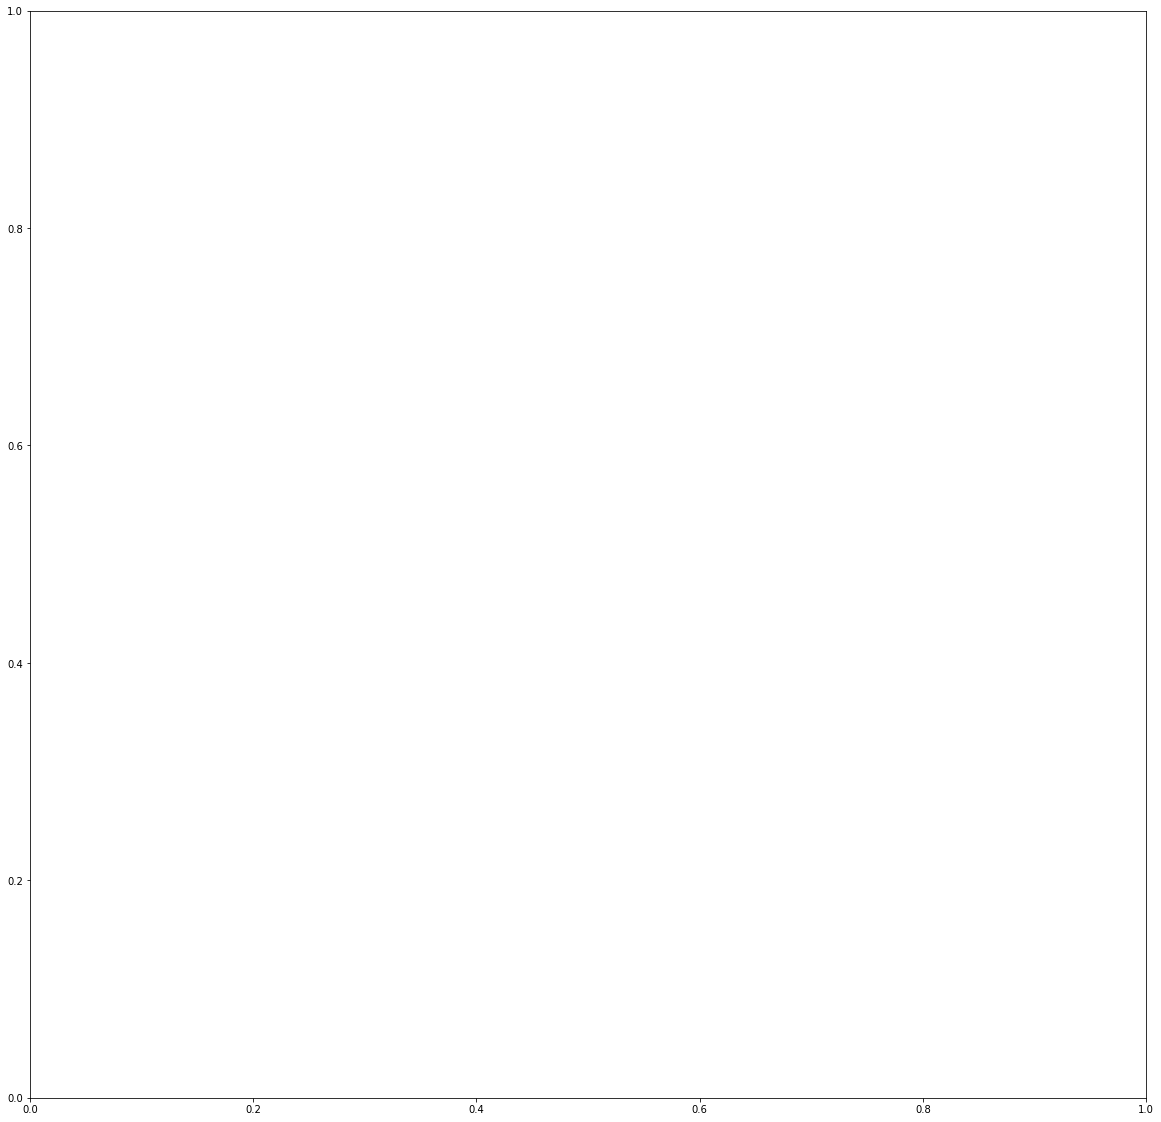

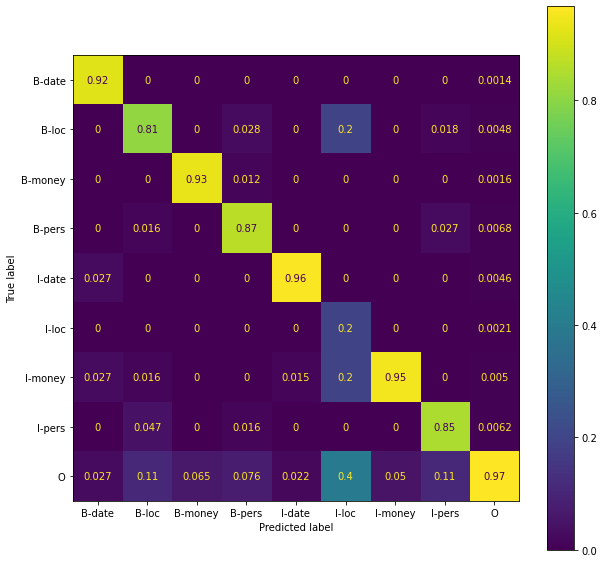

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(20, 20))

labels = ['B-date', 'B-loc', 'B-money', 'B-pers', 'I-date', 'I-loc', 'I-money', 'I-pers', 'O']

fig, ax = plt.subplots(figsize=(10,10))

disp = ConfusionMatrixDisplay.from_predictions(true, predictions,
                           display_labels=labels, normalize='pred', ax=ax)

In [15]:
txt = """Wie jacob van den houke wydoot brunijnc Robrecht lammertijn artur veyse en jehan abelkin Scepene van der poort van veurne doen te wetene 
tallen den gonen die deze lre zullen zien of horen leisen Dat jehan de buc de tanne en pieroene zijn wijf camen voor ons Ende ghauen vp wel en 
wettlike met halme en met ghiften jehan den breden onzen poorte zes sceleghe par. siaers eweliker renten den groten tournoisen ouer 
twalef peninghe par. of andre munte jnt auenant ligghende onder de stede trechof en de recken die jehans van den recke waren daer 
hanekin vranke nu wonende es te gheldene jehan den brede vors. of den ex bringhe van deze  lre te tween payementen jnt jaer / dats te  
wetene dene helt te zinte jehans messe nu eerst"""

doc = nlp(txt)

for ent in doc.ents:
    print(ent.text, ent.label_)

jacob van den houke PERS
brunijnc PERS
Robrecht lammertijn PERS
jehan abelkin PERS
veurne LOC
jehan de buc PERS
jehan den breden PERS

twalef peninghe MONEY
jehans van den recke PERS
jehan den brede PERS
zinte jehans messe DATE


In [16]:
txt = """Wie jacob van den houke wydoot brunijnc Robrecht lammertijn artur veyse en jehan abelkin Scepene van veurne doen te wetene 
tallen den gonen die deze lre zullen zien of horen leisen Dat jehan de buc de tanne en pieroene zijn wijf camen voor ons Ende ghauen vp wel en 
wettlike met halme en met ghiften jehan den breden onzen poorte zes sceleghe par. siaers eweliker renten den groten tournoisen ouer 
twalef peninghe par. of andre munte jnt auenant ligghende onder de stede trechof en de recken die jehans van den recke waren daer 
hanekin vranke nu wonende es te gheldene jehan den brede vors. of den ex bringhe van deze  lre te tween payementen jnt jaer / dats te  
wetene dene helt te zinte jehans messe nu eerst"""

doc = nlp(txt)

for ent in doc.ents:
    print(ent.text,  ent.label_)

jacob van den houke PERS
brunijnc PERS
Robrecht lammertijn PERS
jehan abelkin PERS
veurne LOC
jehan de buc PERS
jehan den breden PERS

twalef peninghe MONEY
jehans van den recke PERS
jehan den brede PERS
zinte jehans messe DATE


In [17]:
import spacy
from spacy import displacy

displacy.render(doc, style="ent")

'<div class="entities" style="line-height: 2.5; direction: ltr">Wie \n<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    jacob van den houke\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PERS</span>\n</mark>\n wydoot \n<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    brunijnc\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PERS</span>\n</mark>\n \n<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    Robrecht lammertijn\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PERS</sp